In [2]:
#importing libraries 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import skbio
import skbio.diversity
import skbio.stats.composition
import scipy

%matplotlib inline

import arivale_data_interface as adi
# apply settings so the lib knows where the data is
adi.apply_isb_config()

#list the local snapshots
local_snapshots = adi.list_local_snapshots()
print(len(local_snapshots))
local_snapshots[0]

98


'/proj/arivale/snapshots/arivale_snapshot_ISB_2020-03-16_2156'

In [3]:
#read in ASV table
asvs = pd.read_csv("/proj/arivale/microbiome/16S_processed/asvs.csv")

#read in samples metadata
samples = pd.read_csv("/proj/arivale/microbiome/16S_processed/metadata.csv")

#read in taxonomy data
tax = pd.read_csv("/proj/arivale/microbiome/16S_processed/taxonomy.csv")

#load in chemistries snapshot 
chemistries = adi.get_snapshot('chemistries')

#load in lifestyle_assessments snapshot  
lifestyle_assessment = adi.get_snapshot('assessments_raw')

#load in medications_assessments snapshot 
medications = adi.get_snapshot('assessments_medications')
#only include patients who have not taken antibiotics in the last three months 
no_antibiotics = medications[medications['meds_antibiotics_last_3_months'].isin(['No'])]

#import Shannon diversity
shannon_trimmed = adi.get_snapshot('microbiome_trimmed_diversity')
shannon = adi.get_snapshot('microbiome_diversity')


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/arivale_data_interface/snapshots_interface.py:271: DeprecationWarning: `assessments_medications` is slated for deprecation and will be part of `assessments` with raw data will be available in `assessments_raw`
  check_deprecation(name) # check if requested snapshot is to be deprecated


In [4]:
all_samples = samples.copy(deep=True)
all_samples_ids = all_samples['id'].values
all_samples.shape

(5232, 24)

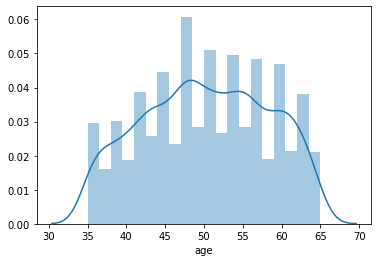

In [5]:
#merge samples with antibiotics data
samples_noab = pd.merge(all_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

#filter out ages in the outside range
samples_over35 = samples_noab[samples_noab['age'] >=35]
age_filtered_samples = samples_over35[samples_over35['age'] <= 65]
age_filtered_samples.shape
sns.distplot(age_filtered_samples['age'])

In [6]:
#filter for baseline samples
baseline_samples = age_filtered_samples.copy(deep=True)
baseline_samples['days_since_first_draw_abs'] = baseline_samples['days_since_first_draw'].abs()
baseline_samples = baseline_samples[baseline_samples['days_since_first_draw'].abs() <= 30]
baseline_samples = baseline_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()

#filter for baseline chemistries
bl_chemistries = chemistries[chemistries['days_since_first_draw'].abs() <= 30]

#merge with insulin data
bl_metadata = pd.merge(baseline_samples,bl_chemistries[['public_client_id','HOMA-IR']],on='public_client_id')

#only include insulin levels above the healthy insulin threshold
bl_metadata = bl_metadata[bl_metadata['HOMA-IR']>=1.9]

bl_metadata['HOMA-IR'].describe()
bl_metadata.shape

(954, 27)

In [7]:
#rename 'days since first draw' column to 'time point'
bl_metadata = bl_metadata.rename(columns={'days_since_first_draw': 'time point'})
#replace all values in the time point column with 0
bl_metadata['time point'] = np.where(bl_metadata['time point'] <= 30, 0, 
                                                bl_metadata['time point'])

In [8]:
#filter for 6month samples
samples2 = age_filtered_samples.copy(deep=True)
samples2['days_since_first_draw_abs'] = samples2['days_since_first_draw'].abs()
samples2 = samples2[samples2['days_since_first_draw'].abs() <= 360]
sixmonth_samples = samples2[samples2['days_since_first_draw'].abs() >30]
sixmonth_samples = sixmonth_samples.sort_values('days_since_first_draw_abs').groupby('public_client_id').first()
sixmonth_samples_ids = sixmonth_samples['id'].values

#merge samples with antibiotics data
sixmonth_noab = pd.merge(sixmonth_samples,no_antibiotics[['public_client_id',
                                                           'meds_antibiotics_last_3_months',]],on='public_client_id')

sixmonth_noab.shape

(995, 27)

In [9]:
#only indlude six month blood draw data for chemistries
baseline_chemistries2 = chemistries.copy(deep=True)
baseline_chemistries2 = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() <= 360]
sixmonth_chemistries = baseline_chemistries2[baseline_chemistries2['days_since_first_draw'].abs() >30]
sixmonth_chemistries.shape

#merge with insulin data
sixmonth_metadata = pd.merge(sixmonth_noab,sixmonth_chemistries[['public_client_id','HOMA-IR']],on='public_client_id')

sixmonth_metadata.shape

(1236, 28)

In [13]:
sixmonth_metadata = sixmonth_metadata.rename(columns={'days_since_first_draw': 'time point'})
sixmonth_metadata['time point'] = np.where(sixmonth_metadata['time point'] <= 360, 6, 
                                                sixmonth_metadata['time point'])

In [14]:
#convert bl_metadata from longform to wide form
bl_long = pd.melt(bl_metadata,id_vars=['public_client_id','time point'],value_vars=['HOMA-IR'])
bl_long =bl_long.drop(['variable'],axis=1)

In [15]:
#convert sixmonth_metadata from longform to wide form
sixmonth_long = pd.melt(sixmonth_metadata,id_vars=['public_client_id','time point'],value_vars=['HOMA-IR'])
sixmonth_long =sixmonth_long.drop(['variable'],axis=1)

In [16]:
#combine baseline and sixmonth metadata
bl6mo_long = [bl_long,sixmonth_long]
bl6mo_longdata = pd.concat(bl6mo_long)
bl6mo_longdata = bl6mo_longdata.rename(columns={'value':'HOMA-IR'})

Text(0.5, 1.0, 'HOMA-IR')

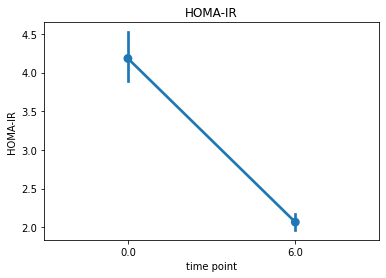

In [17]:
sns.pointplot(x='time point',y='HOMA-IR',data=bl6mo_longdata)
plt.title('HOMA-IR')

In [18]:
#rename 'GLUCOSE' column to 'BL GLUCOSE' in bl_metadata2 dataframe
bl_metadata2 = bl_metadata.rename({'time point':'BL_time_point','HOMA-IR':'BL_HOMA-IR'},axis=1)
bl_metadata2.shape

(954, 27)

In [19]:
# rename 'INSULIN' column to '6MO_INSULIN' in sixmonth_metadata2 dataframe
sixmonth_metadata2 = sixmonth_metadata.rename({'time point':'6mo_time_point','HOMA-IR':'6MO_HOMA-IR'},axis=1)
sixmonth_metadata2.shape

(1236, 28)

In [20]:
#create dataframe of baseline and 6 month insulin data
bl6mo_metadata = pd.merge(bl_metadata2,sixmonth_metadata2[['public_client_id','6mo_time_point','6MO_HOMA-IR']],
                          on='public_client_id')
#bl6mo_metadata = bl6mo_metadata['BL_INSULIN'].dropna()
bl6mo_metadata.shape

(366, 29)

In [21]:
# create empty list for change in insulin
Delta = []

# create for loop that 
for row1 in bl6mo_metadata['BL_HOMA-IR']:
    for row2 in bl6mo_metadata['6MO_HOMA-IR']:
        Delta.append(row1 - row2)

# absolute value of delta        
Delta_abs = [abs(ele) for ele in Delta]

len(Delta_abs)
#add delta column to BL and 6 month metadata
bl6mo_metadata['Delta'] = Delta_abs[0:366]
sns.distplot(bl6mo_metadata['Delta'])

public_client_id      genome_id genome_vendor multiple_genome_ids  \
0         01005100      DS-293608      WUXI_SNP                 NaN   
1         01006695      DS-291353      WUXI_SNP                 NaN   
2         01012626      DS-291365      WUXI_SNP                 NaN   
3         01012626      DS-291365      WUXI_SNP                 NaN   
4         01013950  A752AT594-004      NEXTCODE                 NaN   

   client_id                               user_id sex   race  \
0   268339.0  ec9e8086-1f28-44e8-81f8-f4732d6bda1c   F  white   
1   253022.0  c17dcc57-022d-483e-b3be-1386820f5e19   M  white   
2   246549.0  f3dfc37c-8857-439c-9382-012379e3693b   M  white   
3   246549.0  f3dfc37c-8857-439c-9382-012379e3693b   M  white   
4      490.0  bbbd0d1f-75f8-4572-96aa-92932e1df47c   F  white   

   has_research_consent        enterprise  ... BL_time_point month weekday  \
0                  True  aac0298a21469db8  ...           0.0   Apr     Mon   
1                  True  f1c39fea488575ec  ...           0.0   Mar     Mon   
2                  True  d4cd0dabcf4caa22  ...           0.0   Mar     Tue   
3                  True  d4cd0dabcf4caa22  ...           0.0   Mar     Tue   
4                  True  d4cd0dabcf4caa22  ...           0.0   Oct     Thu   

                            id meds_antibiotics_last_3_months  \
0  22001803512697|GFM-1079-024                             No   
1  22001701510224|GFM-1079-022                             No   
2  22001701512014|GFM-1079-021                             No   
3  22001701512014|GFM-1079-021                             No   
4             AV15-1319|AKE009                             No   

   days_since_first_draw_abs  BL_HOMA-IR 6mo_time_point  6MO_HOMA-IR     Delta  
0                       10.0    2.204938            6.0     2.571111  0.366173  
1                        3.0    2.420000            6.0     1.771852  0.433086  
2                        6.0    3.802469            6.0     3.085185  0.880247  
3                        6.0    3.802469            6.0     3.085185  0.880247  
4                        0.0    2.172840            6.0     1.265185  0.939753  

[5 rows x 30 columns]

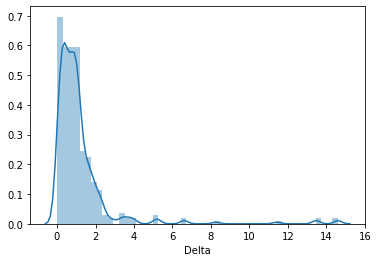

In [22]:
bl6mo_metadata.head()

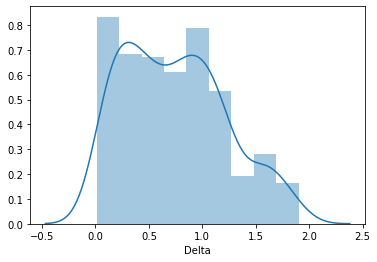

In [40]:
bl6mo_metadata2 = bl6mo_metadata[bl6mo_metadata['Delta']<=1.9]
sns.distplot(bl6mo_metadata2['Delta'])

In [43]:
bl6mo_metadata2.shape

(320, 30)

<ipython-input-48-6c9c34454817>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bl6mo_metadata2['Responder?'] = Responder[0:320]


Text(0.5, 1.0, 'HOMA-IR: Response to Intervention')

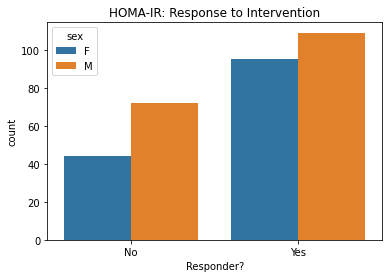

In [48]:
# create empty list for responder data 
Responder = []

for delta in bl6mo_metadata2['Delta']: 
        if delta >= 0.477:
            Responder.append('Yes')
        else:
            Responder.append('No')

#for row1 in bl6mo_metadata['6MO_INSULIN']:    
    #if row1 <= 8:
        #Responder.append('Yes')
    #else:
        #Responder.append('No')

#add responder column to BL and 6 month metadata
bl6mo_metadata2['Responder?'] = Responder[0:320]
sns.countplot(x='Responder?',data=bl6mo_metadata2, hue='sex')
plt.title('HOMA-IR: Response to Intervention')
#bl6mo_metadata2.head()

In [29]:
# drop all unecessary columns in metadata dataframe
metadata_compact = bl6mo_metadata.drop(['genome_id','genome_vendor','coach','multiple_genome_ids','client_id','user_id','race','enterprise',
    'region','country','current_program','latest_program','is_helix','vendor_observation_id','days_in_program',
     'days_since_first_call','month','weekday'],axis=1)
#rename 'id' column to 'sample id'
metadata_compact = metadata_compact.rename({'id':'sample_id'},axis=1)

In [30]:
#merge diversity data to compact metadata
metadata_diversity = pd.merge(metadata_compact,shannon_trimmed[['public_client_id','shannon_50000']],
                                  on='public_client_id')
metadata_diversity.shape

(957, 14)

Text(0.5, 1.0, 'HOMA-IR: Response to Intervention')

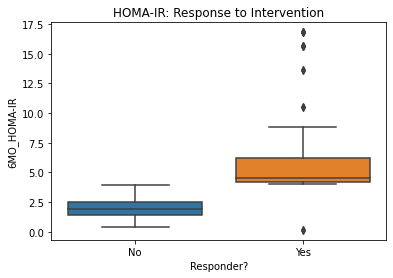

In [31]:
#create boxplot of responder vs. non-responder
sns.boxplot(data=metadata_diversity,x='Responder?',y='6MO_HOMA-IR')
plt.title('HOMA-IR: Response to Intervention')

In [24]:
###########################################################################################
# SETTING UP ASV AND TAXONOMY DATA

In [25]:
#convert ASV table to wide form
asvs_wide=pd.pivot_table(asvs,index='id',columns='hash',values='count', fill_value=0)
asvs_wide_baseline = asvs_wide.loc[asvs_wide.index.isin(all_samples_ids)]

In [26]:
#transpose the asv dataframe
asvsT = asvs_wide_baseline.transpose()
asvsT.head()

id                                22001612560009|GFM-1079-007  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560012|GFM-1079-011  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560014|GFM-1079-016  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560015|GFM-1079-015  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560016|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560017|GFM-1079-009  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560020|GFM-1079-003  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560022|GFM-1079-006  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66d2716                            0   
00030c11306e21d37b6746c3bde4bf04                            0   

id                                22001612560023|GFM-1079-001  \
hash                                                            
00002d83dec0ceabeb1fe4135a2b6ab8                            0   
00018b0d514b0f1a47ce15eaa4d247f6                            0   
0001eda93a1e6802360bf98488c24869                            0   
0002120f916215b077ef0a08d66

In [27]:
#add index to newly transposed asv_samples data
asvsT_index = asvsT.reset_index()
asvsT_index.head()

id                              hash  22001612560009|GFM-1079-007  \
0   00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1   00018b0d514b0f1a47ce15eaa4d247f6                            0   
2   0001eda93a1e6802360bf98488c24869                            0   
3   0002120f916215b077ef0a08d66d2716                            0   
4   00030c11306e21d37b6746c3bde4bf04                            0   

id  22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                             0                            0   
1                             0                            0   
2                             0                            0   
3                             0                            0   
4                             0                            0   

id  22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                             0                            0  ...   
1                             0                            0  ...   
2                             0                            0  ...   
3                             0                            0  ...   
4                             0                            0  ...   

id  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  FLCK|AKE014  MIFN|AKE014  \
0                  0                 0            0            0            0   
1                  0                 0            0            0            0   
2                  0                 0            0            0            0   
3                  0                 0            0            0            0   
4                  0                 0            0            0            0   

id  MUMA|AKE014  NEBZ-2|AKE016  NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
0             0              0            0              0            0  
1             0              0            0              0            0  
2             0              0            0              0            0  
3             0              0            0              0            0  
4             0              0            0              0            0  

[5 rows x 5233 columns]

In [28]:
#taxonomy data: rename the id column to "index" so it can be merged with the asvsamplesT_index dataframe
tax = tax.rename(columns={'id': 'hash'})
tax.head()

Kingdom         Phylum        Class          Order           Family  \
0  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
1  Bacteria     Firmicutes   Clostridia  Clostridiales  Ruminococcaceae   
2  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   
3  Bacteria  Bacteroidetes  Bacteroidia  Bacteroidales   Bacteroidaceae   
4  Bacteria     Firmicutes   Clostridia  Clostridiales  Lachnospiraceae   

              Genus      Species  \
0       Bacteroides     vulgatus   
1  Faecalibacterium  prausnitzii   
2      Agathobacter          NaN   
3       Bacteroides          NaN   
4           Blautia          NaN   

                                            sequence  \
0  GCAGCAGTGAGGAATATTGGTCAATGGGCGAGAGCCTGAACCAGCC...   
1  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   
2  GCAGCAGTGGGGAATATTGCACAATGGGCGAAAGCCTGATGCAGCG...   
3  GCAGCAGTGAGGAATATTGGTCAATGGGCGATGGCCTGAACCAGCC...   
4  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...   

                               hash  
0  c2d3fc09212e226b3a2c3398a1af9436  
1  a425c9ccfd2d87768c9524f0a798ee2d  
2  11e733f60337e5ef6c9a94a66841d20b  
3  7ed48cd35b68995ff96e23b89c9018c5  
4  2582ff55b130be55a786156c3da4dcf8

In [29]:
#merge taxonomy data with asv data
ASV_tax_data = pd.merge(asvsT_index,tax,on='hash')
ASV_tax_data.head()

hash  22001612560009|GFM-1079-007  \
0  00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1  00018b0d514b0f1a47ce15eaa4d247f6                            0   
2  0001eda93a1e6802360bf98488c24869                            0   
3  0002120f916215b077ef0a08d66d2716                            0   
4  00030c11306e21d37b6746c3bde4bf04                            0   

   22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                            0                            0   
1                            0                            0   
2                            0                            0   
3                            0                            0   
4                            0                            0   

   22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                            0                            0  ...   
1                            0                            0  ...   
2                            0                            0  ...   
3                            0                            0  ...   
4                            0                            0  ...   

   QIRL-2|AKE014  QIRL|AKE014   Kingdom         Phylum        Class  \
0              0            0  Bacteria     Firmicutes   Clostridia   
1              0            0  Bacteria  Bacteroidetes  Bacteroidia   
2              0            0  Bacteria     Firmicutes   Clostridia   
3              0            0  Bacteria     Firmicutes   Clostridia   
4              0            0  Bacteria     Firmicutes   Clostridia   

           Order               Family                          Genus  Species  \
0  Clostridiales      Lachnospiraceae                   Anaerostipes      NaN   
1  Bacteroidales       Muribaculaceae                            NaN      NaN   
2  Clostridiales  Christensenellaceae  Christensenellaceae_R-7_group      NaN   
3  Clostridiales      Ruminococcaceae                            NaN      NaN   
4  Clostridiales      Ruminococcaceae                         DTU089      NaN   

                                            sequence  
0  GCAGCAGTGGGGAATATTGCACAATGGGGGAAACCCTGATGCAGCG...  
1  GCAGCAGTGAGGAATATTGGTCAATGGGCGGGAGCCTGAACCAGCC...  
2  GCAGCAGTGGGGAATATTGGGCAATGGGCGAAAGCCTGACCCAGCA...  
3  GCTGCAGTGGGGGATATTGCACAATGGGGGAAACCCTGATGCAGCA...  
4  GCGAGCGTTGTCCGGATTTACTGGGTGTAAAGGGTGCGTAGGTGGA...  

[5 rows x 5241 columns]

In [30]:
#drop the sequence column
ASV_tax_data = ASV_tax_data.drop(['sequence'],axis=1)

In [31]:
#fill NaN values with 0
ASV_tax_data.fillna(0)

hash  22001612560009|GFM-1079-007  \
0      00002d83dec0ceabeb1fe4135a2b6ab8                            0   
1      00018b0d514b0f1a47ce15eaa4d247f6                            0   
2      0001eda93a1e6802360bf98488c24869                            0   
3      0002120f916215b077ef0a08d66d2716                            0   
4      00030c11306e21d37b6746c3bde4bf04                            0   
...                                 ...                          ...   
89017  fffa9d186997056849b930a68dd8b121                            0   
89018  fffbae09f8a62b3498565b4fe8838846                            0   
89019  fffc51faa053251845837ffc43231b30                            0   
89020  fffe4057d41c6ef3b16a370498eb01a9                            0   
89021  ffff9eed68c63035d7f56c61d7603794                            0   

       22001612560012|GFM-1079-011  22001612560014|GFM-1079-016  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560015|GFM-1079-015  22001612560016|GFM-1079-001  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560017|GFM-1079-009  22001612560020|GFM-1079-003  \
0                                0                            0   
1                                0                            0   
2                                0                            0   
3                                0                            0   
4                                0                            0   
...                            ...                          ...   
89017                            0                            0   
89018                            0                            0   
89019                            0                            0   
89020                            0                            0   
89021                            0                            0   

       22001612560022|GFM-1079-006  22001612560023|GFM-1079-001  ...  \
0                                0                            0  ...   
1                                0                            0  ...   
2                                0                            0  ...   
3                                0                            0  ...   
4                                0                            0  ...   
...                            ...                          ...  ...   
89017                            0                            0  ...   
89018                            0                            0  ...   
89019                            0                            0  ...   
89020                            0 

In [32]:
#sum on genus level
genus_counts = ASV_tax_data.groupby(["Genus"]).sum()
#genus_counts.head()

In [33]:
#NORMALIZING DATA

# set genera where total reads for that genera across all samples is < 10
genus_counts_filtered = genus_counts[genus_counts >= 10].fillna(0)

# filter for only genera where abundance > 0
genus_counts_filtered = genus_counts_filtered.loc[genus_counts_filtered.sum(axis=1) > 0,:] 

# filter for samples where the sequencing depth is > 50,000
genus_counts_filtered = genus_counts_filtered.loc[:,genus_counts_filtered.sum() >= 50000]

#normalizing to relative abundance: (count of genus X)/(total count in a sample)
normalized_counts = genus_counts_filtered/genus_counts_filtered.sum()
normalized_counts.head()

22001612560009|GFM-1079-007  22001612560012|GFM-1079-011  \
Genus                                                                           
28-4                                    0.000000                     0.000000   
A2                                      0.000000                     0.000000   
ASF356                                  0.000000                     0.000000   
Abiotrophia                             0.000000                     0.000000   
Acetanaerobacterium                     0.000295                     0.000168   

                     22001612560014|GFM-1079-016  22001612560015|GFM-1079-015  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     22001612560016|GFM-1079-001  22001612560017|GFM-1079-009  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     22001612560020|GFM-1079-003  22001612560022|GFM-1079-006  \
Genus                                                                           
28-4                                         0.0                     0.000000   
A2                                           0.0                     0.000000   
ASF356                                       0.0                     0.000000   
Abiotrophia                                  0.0                     0.000000   
Acetanaerobacterium                          0.0                     0.000114   

                     22001612560023|GFM-1079-001  22001612560027|GFM-1079-003  \
Genus                                                                           
28-4                                         0.0                          0.0   
A2                                           0.0                          0.0   
ASF356                                       0.0                          0.0   
Abiotrophia                                  0.0                          0.0   
Acetanaerobacterium                          0.0                          0.0   

                     ...  AV15-4413|AKE035  AV15-4415|AKE035  CEEX|AKE014  \
Genus                ...                                                    
28-4                 ...               0.0          0.009445          0.0   
A2                   ...               0.0          0.000000          0.0   
ASF356               ...               0.0          0.000000          0.0   
Abiotrophia          ...               0.0          0.000000          0.0   
Acetanaerobacterium  ...               0.0          0.000000          0.0   

                     FLCK|AKE014  MIFN|AKE014  MUMA|AKE014  NEBZ-2|AKE016  \
Genus                                                                       
28-4                    0.010792          0.0          0.0       0.000000   
A2                      0.000000          0.0          0.0       0.000000   
ASF356                  0.000000          0.0          0.0       0.000000   
Abiotrophia             0.000000          0.0          0.0       0.000000   
Acetanaerobacterium     0.000000          0.0          0.0       0.000444   

                     NEBZ|AKE014  QIRL-2|AKE014  QIRL|AKE014  
Genus                                 

In [34]:
######################################################################
# CALCULATING CENTER LOG RATIO FOR ALL DATA

In [35]:
from skbio.stats.composition import clr

In [36]:
# add pseudocount because CLR transform requires that you have non-zero abundances 
normalizedT = skbio.stats.composition.multiplicative_replacement(normalized_counts.T)

# Perform CLR transformation
# https://www.ars.usda.gov/ARSUserFiles/80800505/International%20Workshop/Presentations/Wednesday%20Morning/Adam%20Rivers.pdf

clr_data = skbio.stats.composition.clr(normalizedT)
clr_data = pd.DataFrame(clr_data, 
                        columns = normalized_counts.index, 
                        index = normalized_counts.columns)
clr_data.describe()

Genus         28-4           A2       ASF356  Abiotrophia  \
count  5127.000000  5127.000000  5127.000000  5127.000000   
mean     -0.849100    -1.129673    -1.129685    -1.123811   
std       1.295912     0.233146     0.233729     0.274878   
min      -1.786739    -1.786739    -1.786739    -1.786739   
25%      -1.278667    -1.291326    -1.291526    -1.291326   
50%      -1.127524    -1.148522    -1.148522    -1.148451   
75%      -0.957386    -0.996405    -0.996405    -0.996169   
max       7.899725     1.406389     1.649431     3.664560   

Genus  Acetanaerobacterium  Acetatifactor  Acetitomaculum  Acidaminococcus  \
count          5127.000000    5127.000000     5127.000000      5127.000000   
mean             -0.724227      -1.123842       -1.122209        -0.180443   
std               1.084349       0.282713        0.318152         2.267768   
min              -1.786739      -1.786739       -1.786739        -1.786739   
25%              -1.258029      -1.291071       -1.290725        -1.258122   
50%              -1.099106      -1.148309       -1.148309        -1.093412   
75%              -0.875416      -0.996095       -0.996095        -0.834818   
max               5.047864       4.668521        6.534634         9.112541   

Genus  Acidipropionibacterium   Acidovorax  ...   Vagococcus  Varibaculum  \
count             5127.000000  5127.000000  ...  5127.000000  5127.000000   
mean                -1.129760    -1.129500  ...    -1.128969    -1.060198   
std                  0.233154     0.237183  ...     0.237695     0.578220   
min                 -1.786739    -1.786739  ...    -1.766855    -1.786739   
25%                 -1.291526    -1.291526  ...    -1.291162    -1.286211   
50%                 -1.148549    -1.148549  ...    -1.148461    -1.140875   
75%                 -0.996405    -0.996509  ...    -0.996363    -0.981761   
max                  1.391923     2.886871  ...     2.941162     7.943800   

Genus  Veillonella  Victivallis        W5053    Weissella      XBB1006  \
count  5127.000000  5127.000000  5127.000000  5127.000000  5127.000000   
mean      0.831442     0.006455    -1.126497    -0.994358    -1.125714   
std       2.319068     1.972236     0.253588     0.795348     0.259099   
min      -1.786739    -1.695990    -1.786739    -1.766855    -1.786739   
25%      -1.179655    -1.186110    -1.291071    -1.284744    -1.290936   
50%      -0.767629    -1.003880    -1.148381    -1.137198    -1.148309   
75%       2.699364    -0.200570    -0.996169    -0.972357    -0.996095   
max       9.264536     6.473605     3.097554     7.195113     3.694134   

Genus     Yersinia          Z20  dgA-11_gut_group  
count  5127.000000  5127.000000       5127.000000  
mean     -1.128092    -1.108502         -1.122341  
std       0.248810     0.440411          0.305534  
min      -1.786739    -1.786739         -1.786739  
25%      -1.291326    -1.290155         -1.290725  
50%      -1.148522    -1.147359         -1.148309  
75%      -0.996363    -0.994800         -0.996095  
max       4.363920     7.315159          5.869644  

[8 rows x 421 columns]

In [37]:
#reset index of clr data and rename index column to 'sample_id'
clr_reset = clr_data.reset_index().rename(columns={'index':'sample_id'})
#clr_reset.head()

In [38]:
#merge compact metadata with clr_data and shannon diversity
clr_metadata_div = pd.merge(clr_reset,metadata_diversity,on='sample_id')
clr_metadata_div.head()

sample_id      28-4        A2    ASF356  Abiotrophia  \
0  22001612560084|GFM-1079-008 -0.812026 -0.812026 -0.812026    -0.812026   
1  22001612560084|GFM-1079-008 -0.812026 -0.812026 -0.812026    -0.812026   
2  22001612560436|GFM-1079-014 -1.418771 -1.418771 -1.418771    -1.418771   
3  22001612560436|GFM-1079-014 -1.418771 -1.418771 -1.418771    -1.418771   
4  22001612560436|GFM-1079-014 -1.418771 -1.418771 -1.418771    -1.418771   

   Acetanaerobacterium  Acetatifactor  Acetitomaculum  Acidaminococcus  \
0            -0.812026      -0.812026       -0.812026        -0.812026   
1            -0.812026      -0.812026       -0.812026        -0.812026   
2            -1.418771      -1.418771       -1.418771        -1.418771   
3            -1.418771      -1.418771       -1.418771        -1.418771   
4            -1.418771      -1.418771       -1.418771        -1.418771   

   Acidipropionibacterium  ...   age  BL_time_point  \
0               -0.812026  ...  57.0            0.0   
1               -0.812026  ...  57.0            0.0   
2               -1.418771  ...  49.0            0.0   
3               -1.418771  ...  49.0            0.0   
4               -1.418771  ...  49.0            0.0   

   meds_antibiotics_last_3_months  days_since_first_draw_abs  BL_INSULIN  \
0                              No                        8.0         8.5   
1                              No                        8.0         8.5   
2                              No                       27.0        10.2   
3                              No                       27.0        10.2   
4                              No                       27.0        10.2   

   6mo_time_point  6MO_INSULIN  Delta  Responder?  shannon_50000  
0             6.0          8.4    1.0          No       3.664669  
1             6.0          8.4    1.0          No       3.104606  
2             6.0          9.1    0.3          No       4.416041  
3             6.0          9.1    0.3          No       3.788742  
4             6.0         11.6    2.2          No       4.416041  

[5 rows x 435 columns]

Text(0.5, 1.0, 'Bacteroides Abundance in Responders and Non-responders')

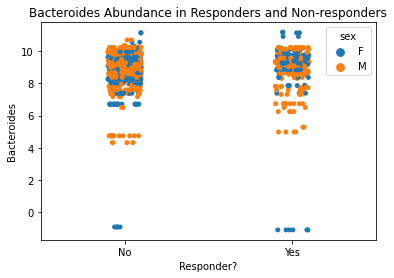

In [157]:
sns.stripplot(data=clr_metadata_div,x='Responder?',y='Bacteroides',hue='sex')
plt.title('Bacteroides Abundance in Responders and Non-responders')

Text(0.5, 1.0, 'Bacteroides Abundance in Responders and Non-responders')

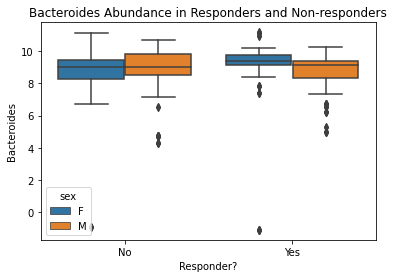

In [158]:
sns.boxplot(data=clr_metadata_div,x='Responder?',y='Bacteroides',hue='sex')
plt.title('Bacteroides Abundance in Responders and Non-responders')

Text(0.5, 1.0, 'Prevotella Abundance in Responders and Non-responders')

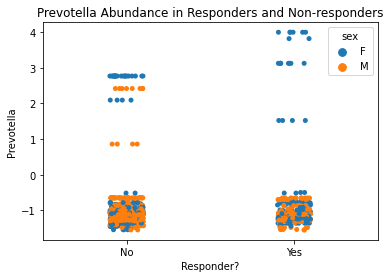

In [159]:
sns.stripplot(data=clr_metadata_div,x='Responder?',y='Prevotella',hue='sex')
plt.title('Prevotella Abundance in Responders and Non-responders')

Text(0.5, 1.0, 'Prevotella Abundance in Responders and Non-responders')

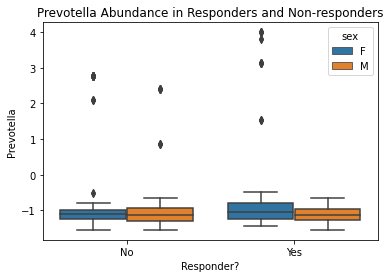

In [160]:
sns.boxplot(data=clr_metadata_div,x='Responder?',y='Prevotella',hue='sex')
plt.title('Prevotella Abundance in Responders and Non-responders')

Text(0.5, 1.0, 'Ruminococcus Abundance in Responders and Non-responders')

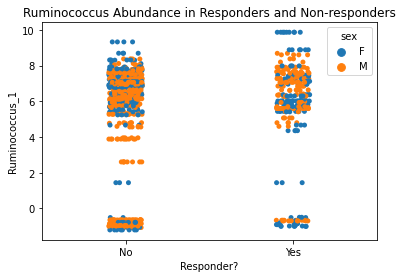

In [161]:
sns.stripplot(data=clr_metadata_div,x='Responder?',y='Ruminococcus_1',hue='sex')
plt.title('Ruminococcus Abundance in Responders and Non-responders')

Text(0.5, 1.0, 'Ruminococcus Abundance in Responders and Non-responders')

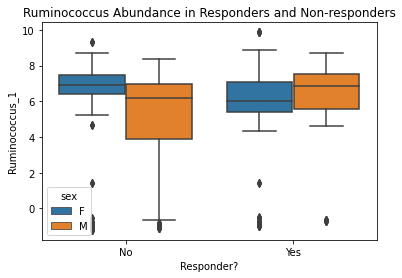

In [162]:
sns.boxplot(data=clr_metadata_div,x='Responder?',y='Ruminococcus_1',hue='sex')
plt.title('Ruminococcus Abundance in Responders and Non-responders')

In [40]:
# create smaller dataframe of responder baseline gut microbiome
responder_microbiome = clr_metadata_div[clr_metadata_div['Responder?']=='Yes']
responder_microbiome.shape

(303, 435)

In [41]:
# create smaller dataframe of non-responder baseline gut microbiome
nonresponder_microbiome = clr_metadata_div[clr_metadata_div['Responder?']=='No']
nonresponder_microbiome.shape

(798, 435)

In [42]:
#Perform Mann-Whitney U Test
import scipy.stats as stats

In [43]:
# QUESTION to answer: are the bacteroides population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_bacteroides_list = [];
for ele in responder_microbiome['Bacteroides']:
        responder_bacteroides_list.append(ele)
        
# convert responder list to array 
responder_bacteroides_array = np.array(responder_bacteroides_list)

# for loop that stores all non-responders in a list 
nonresponder_bacteroides_list = [];
for ele in nonresponder_microbiome['Bacteroides']:
        nonresponder_bacteroides_list.append(ele)
    
# convert non-responder list to array
nonresponder_bacteroides_array = np.array(nonresponder_bacteroides_list)

# calculate u and the probability of a difference
u_statistic, pVal1 = stats.mannwhitneyu(responder_bacteroides_array,nonresponder_bacteroides_array)
print(pVal1)

0.008739825725893


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/scipy/stats/stats.py:6388: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  warnings.warn("Calling `mannwhitneyu` without specifying "


In [44]:
# QUESTION to answer: are the prevotella population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_prevotella_list = [];
for ele in responder_microbiome['Prevotella']:
        responder_prevotella_list.append(ele)
        
# convert responder list to array 
responder_prevotella_array = np.array(responder_prevotella_list)

# for loop that stores all non-responders in a list 
nonresponder_prevotella_list = [];
for ele in nonresponder_microbiome['Prevotella']:
        nonresponder_prevotella_list.append(ele)
    
# convert non-responder list to array
nonresponder_prevotella_array = np.array(nonresponder_prevotella_list)

# calculate u and the probability of a difference
u_statistic, pVal2 = stats.mannwhitneyu(responder_prevotella_array,nonresponder_prevotella_array)
print(pVal2)

0.03396223099429009


In [46]:
# QUESTION to answer: are the ruminococcus population significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_ruminococcus_list = [];
for ele in responder_microbiome['Ruminococcus_1']:
        responder_ruminococcus_list.append(ele)
        
# convert responder list to array 
responder_ruminococcus_array = np.array(responder_ruminococcus_list)

# for loop that stores all non-responders in a list 
nonresponder_ruminococcus_list = [];
for ele in nonresponder_microbiome['Ruminococcus_1']:
        nonresponder_ruminococcus_list.append(ele)
    
# convert non-responder list to array
nonresponder_ruminococcus_array = np.array(nonresponder_ruminococcus_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_ruminococcus_array,nonresponder_ruminococcus_array)
print(pVal3)

0.41575634549417867


In [48]:
# QUESTION to answer: are the insulin levels after 6 months significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_ruminococcus_list = [];
for ele in responder_microbiome['6MO_INSULIN']:
        responder_ruminococcus_list.append(ele)
        
# convert responder list to array 
responder_ruminococcus_array = np.array(responder_ruminococcus_list)

# for loop that stores all non-responders in a list 
nonresponder_ruminococcus_list = [];
for ele in nonresponder_microbiome['6MO_INSULIN']:
        nonresponder_ruminococcus_list.append(ele)
    
# convert non-responder list to array
nonresponder_ruminococcus_array = np.array(nonresponder_ruminococcus_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_ruminococcus_array,nonresponder_ruminococcus_array)
print(pVal3)

3.855298042086231e-09


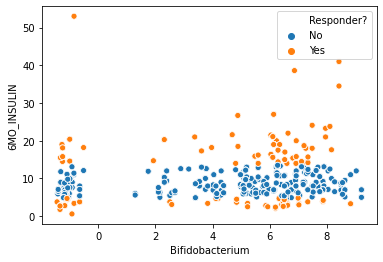

In [54]:
sns.scatterplot(x='Bifidobacterium',y='6MO_INSULIN',data=clr_metadata_div,hue='Responder?')

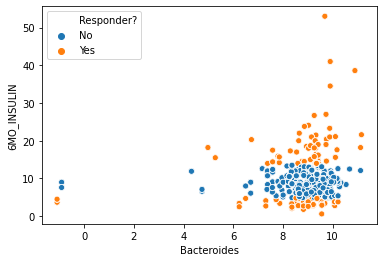

In [55]:
sns.scatterplot(x='Bacteroides',y='6MO_INSULIN',data=clr_metadata_div,hue='Responder?')

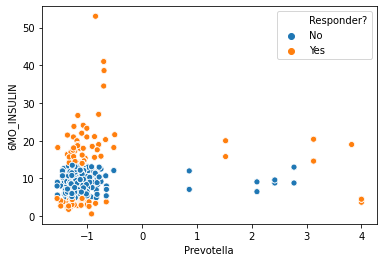

In [56]:
sns.scatterplot(x='Prevotella',y='6MO_INSULIN',data=clr_metadata_div,hue='Responder?')

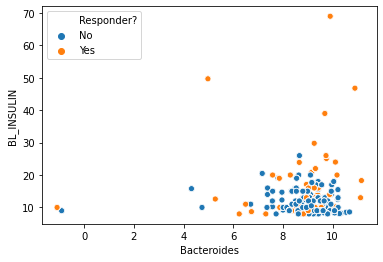

In [57]:
sns.scatterplot(x='Bacteroides',y='BL_INSULIN',data=clr_metadata_div,hue='Responder?')

In [85]:
# QUESTION to answer: is shannon diversity significantly different between the two groups?
#split responders vs non-responders into two separate arrays

#for loop that stores all responders in a list
responder_ruminococcus_list = [];
for ele in responder_microbiome['shannon_50000']:
        responder_ruminococcus_list.append(ele)
        
# convert responder list to array 
responder_ruminococcus_array = np.array(responder_ruminococcus_list)

# for loop that stores all non-responders in a list 
nonresponder_ruminococcus_list = [];
for ele in nonresponder_microbiome['shannon_50000']:
        nonresponder_ruminococcus_list.append(ele)
    
# convert non-responder list to array
nonresponder_ruminococcus_array = np.array(nonresponder_ruminococcus_list)

# calculate u and the probability of a difference
u_statistic, pVal3 = stats.mannwhitneyu(responder_ruminococcus_array,nonresponder_ruminococcus_array)
print(pVal3)

0.01908420635567212


/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/scipy/stats/stats.py:6388: DeprecationWarning: Calling `mannwhitneyu` without specifying `alternative` is deprecated.
  warnings.warn("Calling `mannwhitneyu` without specifying "


Text(0.5, 1.0, 'Responder Shannon Diverstiy Distribution')

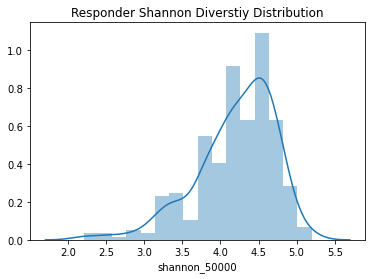

In [165]:
sns.distplot(responder_microbiome['shannon_50000'])
plt.title('Responder Shannon Diverstiy Distribution')

Text(0.5, 1.0, 'Non-Responder Shannon Diverstiy Distribution')

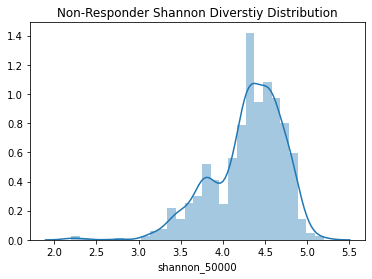

In [167]:
sns.distplot(nonresponder_microbiome['shannon_50000'])
plt.title('Non-Responder Shannon Diverstiy Distribution')

Text(0.5, 1.0, 'Shannon Diversity')

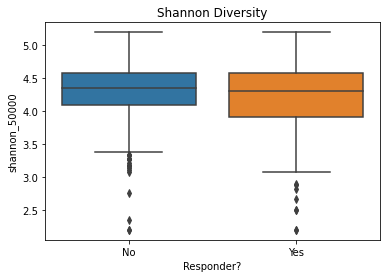

In [169]:
sns.boxplot(x='Responder?',y='shannon_50000',data=clr_metadata_div)
plt.title('Shannon Diversity')

In [60]:
###################################
#LOGISTIC REGRESSION

In [61]:
# create a dummy variable for Responder column in clr_metadata_div table
responder_ml = pd.get_dummies(clr_metadata_div['Responder?'],drop_first=True)

# concatenate the dummy variable table with the 
ml_data = pd.concat([clr_metadata_div,responder_ml],axis=1)
#list(ml_data.columns)

In [62]:
# drop non-numerical columns
ml_data.drop(['sample_id','public_client_id','sex','has_research_consent','meds_antibiotics_last_3_months',
 'days_since_first_draw_abs','BL_INSULIN','6mo_time_point','age','BL_time_point','6MO_INSULIN',
              'Delta','Responder?'],axis=1,inplace=True)
ml_microbiome = ml_data.rename({'Yes':'Responder'},axis=1).dropna()
ml_microbiome.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Veillonella  Victivallis     W5053  Weissella   XBB1006  \
0   -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
1   -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
2   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
3   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
4   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   

   Yersinia       Z20  dgA-11_gut_group  shannon_50000  Responder  
0 -0.812026 -0.812026         -0.812026       3.664669          0  
1 -0.812026 -0.812026         -0.812026       3.104606          0  
2 -1.418771 -1.418771         -1.418771       4.416041          0  
3 -1.418771 -1.418771         -1.418771       3.788742          0  
4 -1.418771 -1.418771         -1.418771       4.416041          0  

[5 rows x 423 columns]

In [63]:
#separate X and y variables. y is what you are trying to predict, which in this case is whether a participant is a 
#responder or not

X = ml_microbiome.drop(['Responder'],axis=1)
y = ml_microbiome['Responder']

In [64]:
from sklearn.model_selection import train_test_split

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
#create an instance of logistic regression
logmodel = LogisticRegression()

In [68]:
#fit the model
logmodel.fit(X_train,y_train)

/users/soluoch/miniconda3/envs/arivale/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [69]:
predictions = logmodel.predict(X_test)

In [70]:
from sklearn.metrics import classification_report

In [71]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       231
           1       0.80      0.64      0.71       100

    accuracy                           0.84       331
   macro avg       0.83      0.79      0.80       331
weighted avg       0.84      0.84      0.84       331



In [72]:
from sklearn.metrics import confusion_matrix

Text(0.5, 257.44, 'Predicted Label')

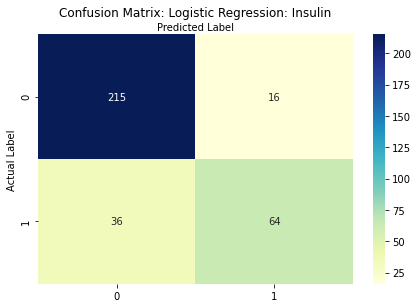

In [170]:
# confusion matrix
cnf_matrix_lr = confusion_matrix(y_test,predictions)
cnf_matrix_lr
# visualizing confusion matrix using heat map

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heat map
sns.heatmap(pd.DataFrame(cnf_matrix_lr),annot=True,cmap="YlGnBu",fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: Logistic Regression: Insulin',y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


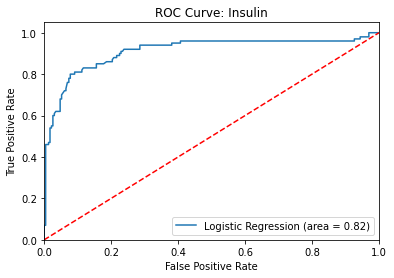

In [171]:
# creating an ROC curve

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logmodel.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logmodel.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Insulin')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [77]:
# create an ml version of the responder microbiome
ml_responder_data = responder_microbiome.copy()
ml_responder_data.drop(['sample_id', 'public_client_id',
 'sex','has_research_consent','age','BL_time_point','meds_antibiotics_last_3_months',
    'days_since_first_draw_abs','BL_INSULIN','6mo_time_point','6MO_INSULIN','Delta',
    'Responder?','shannon_50000'], axis=1, inplace=True)
ml_responder_data.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
22 -0.515252 -0.515252 -0.515252    -0.515252            -0.515252   
23 -0.515252 -0.515252 -0.515252    -0.515252            -0.515252   
40 -0.749284 -0.749284 -0.749284    -0.749284            -0.749284   
41 -0.749284 -0.749284 -0.749284    -0.749284            -0.749284   
44 -0.749284 -0.749284 -0.749284    -0.749284            -0.749284   

    Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
22      -0.515252       -0.515252        -0.515252               -0.515252   
23      -0.515252       -0.515252        -0.515252               -0.515252   
40      -0.749284       -0.749284        -0.749284               -0.749284   
41      -0.749284       -0.749284        -0.749284               -0.749284   
44      -0.749284       -0.749284        -0.749284               -0.749284   

    Acidovorax  ...  Vagococcus  Varibaculum  Veillonella  Victivallis  \
22   -0.515252  ...   -0.515252    -0.515252     3.022035    -0.515252   
23   -0.515252  ...   -0.515252    -0.515252     3.022035    -0.515252   
40   -0.749284  ...   -0.749284    -0.749284    -0.749284    -0.749284   
41   -0.749284  ...   -0.749284    -0.749284    -0.749284    -0.749284   
44   -0.749284  ...   -0.749284    -0.749284    -0.749284    -0.749284   

       W5053  Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  
22 -0.515252  -0.515252 -0.515252 -0.515252 -0.515252         -0.515252  
23 -0.515252  -0.515252 -0.515252 -0.515252 -0.515252         -0.515252  
40 -0.749284  -0.749284 -0.749284 -0.749284 -0.749284         -0.749284  
41 -0.749284  -0.749284 -0.749284 -0.749284 -0.749284         -0.749284  
44 -0.749284  -0.749284 -0.749284 -0.749284 -0.749284         -0.749284  

[5 rows x 421 columns]

Text(0.5, 1.0, 'Responder Gut Genera Counts')

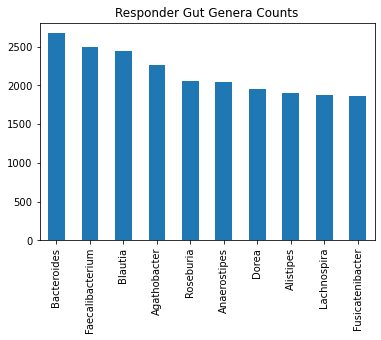

In [195]:
# responder top genera
responder_sums = ml_responder_data.sum().abs()
responder_sums
responder_top_genera = responder_sums.sort_values(ascending=False)
responder_top_genera
df1 = responder_top_genera[:10]
#df1.plot(kind='bar',title='Responder Gut Microbiota',x='Gut Genera',y='Relative Abundance')
df1.plot.bar()
plt.title('Responder Gut Genera Counts')

In [79]:
# create ml version of nonresponder data
ml_nonresponder_data = nonresponder_microbiome.copy()
ml_nonresponder_data.drop(['sample_id', 'public_client_id',
 'sex','has_research_consent','age','BL_time_point','meds_antibiotics_last_3_months',
    'days_since_first_draw_abs','BL_INSULIN','6mo_time_point','6MO_INSULIN','Delta',
    'Responder?','shannon_50000'], axis=1, inplace=True)
ml_nonresponder_data.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Vagococcus  Varibaculum  Veillonella  Victivallis  \
0   -0.812026  ...   -0.812026    -0.812026    -0.812026    -0.812026   
1   -0.812026  ...   -0.812026    -0.812026    -0.812026    -0.812026   
2   -1.418771  ...   -1.418771    -1.418771     3.319649    -1.418771   
3   -1.418771  ...   -1.418771    -1.418771     3.319649    -1.418771   
4   -1.418771  ...   -1.418771    -1.418771     3.319649    -1.418771   

      W5053  Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  
0 -0.812026  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026  
1 -0.812026  -0.812026 -0.812026 -0.812026 -0.812026         -0.812026  
2 -1.418771  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771  
3 -1.418771  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771  
4 -1.418771  -1.418771 -1.418771 -1.418771 -1.418771         -1.418771  

[5 rows x 421 columns]

Text(0.5, 1.0, 'Non-responder Gut Genera Counts')

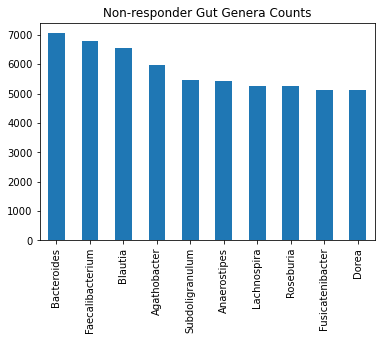

In [194]:
# nonresponder top genera
nonresponder_sums = ml_nonresponder_data.sum().abs()
nonresponder_sums
nonresponder_top_genera = nonresponder_sums.sort_values(ascending=False)
nonresponder_top_genera
df2 = nonresponder_top_genera[:10]
df2.plot(kind='bar')
plt.title('Non-responder Gut Genera Counts')

In [81]:
# looking at bacteroidetes,prevotella,ruminococcus relative abundances in responders 
responder3 = ml_responder_data[['Bacteroides','Prevotella','Ruminococcus_1']]
responder3_sums = responder3.sum().abs()
responder3_sums

Bacteroides       2671.323998
Prevotella         246.351804
Ruminococcus_1    1724.234982
dtype: float64

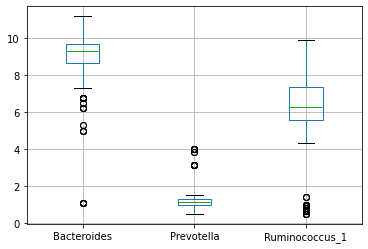

In [82]:
# create boxplot from summed responder data
#responder_dict = {'Bacteroides': [2671.323998],'Prevotella':[246.351804],'Ruminococcus_1':[1724.234982]}
#responder_df = pd.DataFrame(data=responder_dict)
responder_boxplot = ml_responder_data[['Bacteroides',
                                       'Prevotella','Ruminococcus_1']].abs().boxplot(column=['Bacteroides',
                                    'Prevotella','Ruminococcus_1'])

In [83]:
# looking at bacteroidetes,prevotella,ruminococcus relative abundances in non-responders 
nonresponder3 = ml_nonresponder_data[['Bacteroides','Prevotella','Ruminococcus_1']]
nonresponder3_sums = nonresponder3.sum().abs()
nonresponder3_sums

Bacteroides       7052.833523
Prevotella         772.445911
Ruminococcus_1    4425.794075
dtype: float64

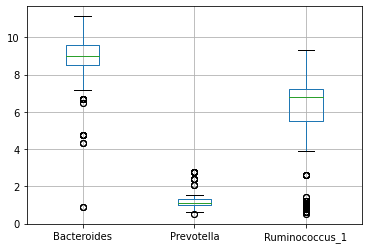

In [84]:
# create boxplot from summed nonresponder data
#nonresponder_dict = {'Bacteroides': [2671.323998],'Prevotella':[246.351804],'Ruminococcus_1':[1724.234982]}
#responder_df = pd.DataFrame(data=responder_dict)
nonresponder_boxplot = ml_nonresponder_data[['Bacteroides',
                                       'Prevotella','Ruminococcus_1']].abs().boxplot(column=['Bacteroides',
                                    'Prevotella','Ruminococcus_1'])

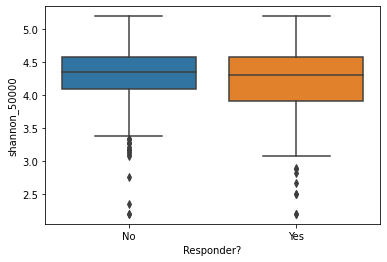

In [119]:
sns.boxplot(data=clr_metadata_div,x='Responder?',y='shannon_50000')

In [123]:
nonresponder_microbiome['shannon_50000'].describe()

count    798.000000
mean       4.291206
std        0.420456
min        2.202129
25%        4.090608
50%        4.359896
75%        4.586555
max        5.197218
Name: shannon_50000, dtype: float64

In [124]:
responder_microbiome['shannon_50000'].describe()

count    303.000000
mean       4.202329
std        0.522020
min        2.202129
25%        3.914549
50%        4.299592
75%        4.580663
max        5.197218
Name: shannon_50000, dtype: float64

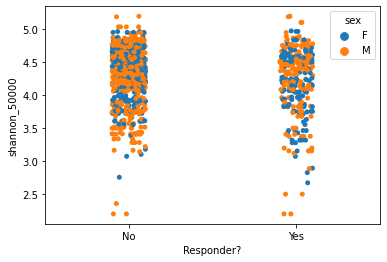

In [89]:
sns.stripplot(x='Responder?',y='shannon_50000',data=clr_metadata_div,hue='sex')

In [102]:
#############################################################################
#K NEAREST NEIGHBORS

In [103]:
ml_microbiome.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
1 -0.812026 -0.812026 -0.812026    -0.812026            -0.812026   
2 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
3 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   
4 -1.418771 -1.418771 -1.418771    -1.418771            -1.418771   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0      -0.812026       -0.812026        -0.812026               -0.812026   
1      -0.812026       -0.812026        -0.812026               -0.812026   
2      -1.418771       -1.418771        -1.418771               -1.418771   
3      -1.418771       -1.418771        -1.418771               -1.418771   
4      -1.418771       -1.418771        -1.418771               -1.418771   

   Acidovorax  ...  Veillonella  Victivallis     W5053  Weissella   XBB1006  \
0   -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
1   -0.812026  ...    -0.812026    -0.812026 -0.812026  -0.812026 -0.812026   
2   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
3   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   
4   -1.418771  ...     3.319649    -1.418771 -1.418771  -1.418771 -1.418771   

   Yersinia       Z20  dgA-11_gut_group  shannon_50000  Responder  
0 -0.812026 -0.812026         -0.812026       3.664669          0  
1 -0.812026 -0.812026         -0.812026       3.104606          0  
2 -1.418771 -1.418771         -1.418771       4.416041          0  
3 -1.418771 -1.418771         -1.418771       3.788742          0  
4 -1.418771 -1.418771         -1.418771       4.416041          0  

[5 rows x 423 columns]

In [104]:
#standardize everything to the same scale
from sklearn.preprocessing import StandardScaler

In [105]:
scaler = StandardScaler()

In [106]:
scaler.fit(ml_microbiome.drop('Responder',axis=1))

StandardScaler()

In [107]:
scaled_feat = scaler.transform(ml_microbiome.drop('Responder',axis=1))

In [108]:
df_feat=pd.DataFrame(scaled_feat,columns=ml_microbiome.columns[:-1])

In [109]:
df_feat.head()

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0 -0.301607  1.436939  1.436939     1.436939             0.121544   
1 -0.301607  1.436939  1.436939     1.436939             0.121544   
2 -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   
3 -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   
4 -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   

   Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0       0.915765        1.436939        -0.116568                1.436939   
1       0.915765        1.436939        -0.116568                1.436939   
2      -0.986087       -1.399711        -0.475025               -1.399711   
3      -0.986087       -1.399711        -0.475025               -1.399711   
4      -0.986087       -1.399711        -0.475025               -1.399711   

   Acidovorax  ...  Varibaculum  Veillonella  Victivallis     W5053  \
0    1.436939  ...     0.546007    -0.657703    -0.460697  1.436939   
1    1.436939  ...     0.546007    -0.657703    -0.460697  1.436939   
2   -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   
3   -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   
4   -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   

   Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  shannon_50000  
0   0.875909  1.436939  1.436939  0.919641          0.641304      -1.332063  
1   0.875909  1.436939  1.436939  0.919641          0.641304      -2.571172  
2  -0.978966 -1.399711 -1.399711 -0.961172         -0.735959       0.330305  
3  -0.978966 -1.399711 -1.399711 -0.961172         -0.735959      -1.057558  
4  -0.978966 -1.399711 -1.399711 -0.961172         -0.735959       0.330305  

[5 rows x 422 columns]

In [182]:
from sklearn.model_selection import train_test_split

In [183]:
X=df_feat
y=ml_microbiome['Responder']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3, random_state=101)

In [184]:
from sklearn.neighbors import KNeighborsClassifier

In [185]:
knn = KNeighborsClassifier(n_neighbors=1)

In [186]:
knn.fit(X_train1,y_train1)

KNeighborsClassifier(n_neighbors=1)

In [187]:
pred1 = knn.predict(X_test1)

In [188]:
from sklearn.metrics import classification_report,confusion_matrix

In [193]:

print(classification_report(y_test1,pred1))

              precision    recall  f1-score   support

           0       0.86      0.91      0.88       231
           1       0.76      0.65      0.70       100

    accuracy                           0.83       331
   macro avg       0.81      0.78      0.79       331
weighted avg       0.83      0.83      0.83       331



Text(0.5, 257.44, 'Predicted Label')

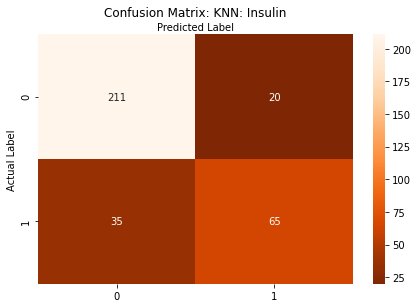

In [192]:
# confusion matrix
cnf_matrix_knn = confusion_matrix(y_test1,pred1)
cnf_matrix_knn
# visualizing confusion matrix using heat map

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heat map
sns.heatmap(pd.DataFrame(cnf_matrix_knn),annot=True,cmap="Oranges_r",fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion Matrix: KNN: Insulin',y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')


In [120]:
#use elbow method to choose a better k value

#iterate many models and see which one has the lowest error
error_rate= []
for i in range(1,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i !=y_test))

Text(0, 0.5, 'Error Rate')

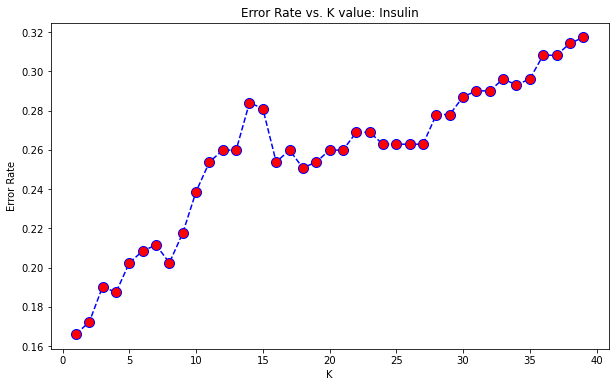

In [172]:
plt.figure(figsize=(10,6))
plt.plot(range(1,40),error_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Error Rate vs. K value: Insulin')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [117]:
#!pip install mlxtend

In [122]:
import mlxtend

In [123]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, neighbors
from mlxtend.plotting import plot_decision_regions

In [146]:
ml_microbiome_compact = ml_microbiome[['Bacteroides','Prevotella','Responder']].copy()

# function for plotting knn
def knn_comparison(data, k):
    x = data[['Bacteroides']].values
    y = data[['Responder']].astype(int).values
    clf = neighbors.KNeighborsClassifier(n_neighbors=k)
    clf.fit(x,y)
    # plotting decision region
    plot_decision_regions(x,y,clf=clf,legend=2)
    # adding axes annotations
    plt.title('Knn with K='+str(k))
    plt.show()

In [137]:
df_feat

28-4        A2    ASF356  Abiotrophia  Acetanaerobacterium  \
0    -0.301607  1.436939  1.436939     1.436939             0.121544   
1    -0.301607  1.436939  1.436939     1.436939             0.121544   
2    -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   
3    -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   
4    -0.559247 -1.399711 -1.399711    -1.399711            -0.591906   
...        ...       ...       ...          ...                  ...   
1096 -0.609726 -1.955489 -1.955489    -1.955489            -0.731691   
1097 -0.238013  2.137113  2.137113     2.137113             0.297646   
1098 -0.238013  2.137113  2.137113     2.137113             0.297646   
1099 -0.426903  0.057417  0.057417     0.057417            -0.225421   
1100 -0.426903  0.057417  0.057417     0.057417            -0.225421   

      Acetatifactor  Acetitomaculum  Acidaminococcus  Acidipropionibacterium  \
0          0.915765        1.436939        -0.116568                1.436939   
1          0.915765        1.436939        -0.116568                1.436939   
2         -0.986087       -1.399711        -0.475025               -1.399711   
3         -0.986087       -1.399711        -0.475025               -1.399711   
4         -0.986087       -1.399711        -0.475025               -1.399711   
...             ...             ...              ...                     ...   
1096      -1.358713       -1.955489        -0.545257               -1.955489   
1097       1.385201        2.137113         3.563533                2.137113   
1098       1.385201        2.137113         3.563533                2.137113   
1099      -0.009145        0.057417         2.588188                0.057417   
1100      -0.009145        0.057417         2.588188                0.057417   

      Acidovorax  ...  Varibaculum  Veillonella  Victivallis     W5053  \
0       1.436939  ...     0.546007    -0.657703    -0.460697  1.436939   
1       1.436939  ...     0.546007    -0.657703    -0.460697  1.436939   
2      -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   
3      -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   
4      -1.399711  ...    -0.747727     1.049384    -0.773123 -1.399711   
...          ...  ...          ...          ...          ...       ...   
1096   -1.955489  ...    -1.001205    -0.957509    -0.834336 -1.955489   
1097    2.137113  ...     0.865341    -0.595825    -0.383580  2.137113   
1098    2.137113  ...     0.865341    -0.595825    -0.383580  2.137113   
1099    0.057417  ...    -0.083163     0.957954    -0.612636  0.057417   
1100    0.057417  ...    -0.083163     0.957954    -0.612636  0.057417   

      Weissella   XBB1006  Yersinia       Z20  dgA-11_gut_group  shannon_50000  
0      0.875909  1.436939  1.436939  0.919641          0.641304      -1.332063  
1      0.875909  1.436939  1.436939  0.919641          0.641304      -2.571172  
2     -0.978966 -1.399711 -1.399711 -0.961172         -0.735959       0.330305  
3     -0.978966 -1.399711 -1.399711 -0.961172         -0.735959      -1.057558  
4     -0.978966 -1.399711 -1.399711 -0.961172         -0.735959       0.330305  
...         ...       ...       ...       ...               ...            ...  
1096  -1.342388 -1.955489 -1.955489 -1.329675         14.508665       0.163148  
1097   1.333751  2.137113  2.137113  1.383885          0.981256      -2.312002  
1098   1.333751  2.137113  2.137113  1.383885          0.981256      -4.221272  
1099  -0.026155  0.057417  0.057417  0.004962         -0.028488      -0.425735  
1100  -0.026155  0.057417  0.057417  0.004962         -0.028488       0.230625  

[1101 rows x 422 columns]